<a href="https://colab.research.google.com/github/B34R-e/Basic-Machine-Learning/blob/main/Basic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Retrieval.**

#### **1. Import necessary libraries.**

In [18]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### **2. Read the data.**

In [19]:
!unzip /content/drive/MyDrive/image_retrieval_dataset.zip

Archive:  /content/drive/MyDrive/image_retrieval_dataset.zip
replace images_mr/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
dataset_dir = '/content/images_mr' # Declare the images's directory.

image_filenames = os.listdir(dataset_dir) # Retrieve the list of file names.

src_images = [] # Declare an empty list for storing images have been read.

for filename in image_filenames: # Browse through file name one by one.

  filepath = os.path.join(    # Declare each image's path
      dataset_dir, filename   # by joining the image's folder and image's name
  )                           # using os.path.join().

  image = cv2.imread(filepath) # Read the image
  image = cv2.cvtColor(        # Change the color channel
      image, cv2.COLOR_BGR2RGB # from BGR (Default of OpenCV)
  )                            # to RGB.

  src_images.append(image)     # Add the image has been processed to src_images.

#### **3. Pre-processing data.**

**Resizing**

In [21]:
# Change all image to the same size. Default is (64x64)
def image_resize(images, target_size=(64, 64)):
  resized_image = cv2.resize(images,target_size)

  return resized_image

**Normalizing**

In [22]:
# Normalize the values using Z-score Normalization
# X(normalized) = (X - mean(I)) / std(I) [with X is an image and I is a list of images]
def calculate_mean_std(images):
  mean = np.mean(images, axis=(0, 1, 2))
  std = np.std(images, axis=(0, 1, 2))

  return mean, std

In [23]:
def image_std_normalize(images, mean, std):
  normalized_image = (images - mean) / std

  return normalized_image

**Flattening**

In [24]:
# To make it easier to calculate the similarity of pics's pairs.
# We need to change each pic to 1D vector by FLATTENING.
def image_flatten(images, is_batch=False):
  if is_batch:
    flattened_image = images.reshape(images.shape[0], -1)
  else:
    flattened_image = images.reshape(-1)

  return flattened_image

**Preprocessing function for IMAGES LIST**

In [25]:
def preprocess_batches(images = src_images):
  resized_images = [
      image_resize(image) for image in images
  ]
  images_arr = np.array(resized_images)
  mean, std = calculate_mean_std(images_arr)
  normalized_images = image_std_normalize(
      images = images_arr,
      mean = mean,
      std = std
      )
  flattened_images = image_flatten(
      images = normalized_images,
      is_batch = True
  )

  return flattened_images, mean, std

**Preprocessing function for QUERY IMAGES**

In [55]:
def preprocess_query(image, mean, std):
  resized_image = image_resize(image)
  normalized_image = image_std_normalize(resized_image, mean, std)
  flattened_image = image_flatten(normalized_image)

  return flattened_image

**Similarity Computing Function**

In [27]:
def mean_absolute_error(query_vector, src_vectors):
  abs_diff = np.abs(query_vector - src_vectors)
  mae = np.mean(abs_diff, axis=1)

  return mae

In [28]:
def mean_squared_error(query_vector, src_vectors):
  squared_diff = (query_vector - src_vectors)**2
  mse = np.mean(squared_diff, axis=1)

  return mse

In [48]:
def cosine_similarity(query_vector, src_vectors):
  query_norm = np.linalg.norm(query_vector)
  normalized_query = query_vector/query_norm
  src_norms = np.linalg.norm(src_vectors, axis=1)
  normalized_src = src_vectors / src_norms[:, np.newaxis]

  cosine_similarity = np.dot(normalized_src, normalized_query)

  return cosine_similarity

In [30]:
def correlation_coefficient(query_vector, src_vectors):
  return np.corrcoef(query_vector, src_vectors)[:-1, -1]

**Ranking Function**

In [35]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
  scores = cosine_similarity(
      preprocessed_query_image,
      preprocessed_src_images
  )
  ranked_list = np.argsort(scores)[::-1][:top_k]
  scores = scores[ranked_list]

  return ranked_list, scores

#### **4. Test Query**

In [ ]:
# query_image_path = '/content/images_mr/1885.jpg'
# top_k = 10
# preprocessed_src_images = preprocess_batches(src_images)
# query_image = cv2.imread(query_image_path, 1)
# query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
# preprocessed_query_image = preprocess_query(query_image)

[-1.14291438 -1.12796031 -0.7915559  ... -1.24381375 -1.21958307
 -1.11004419]
Query Image


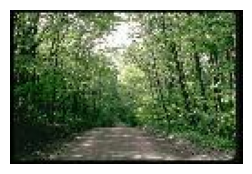

Top 10 results


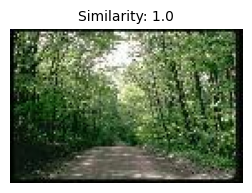

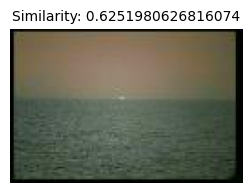

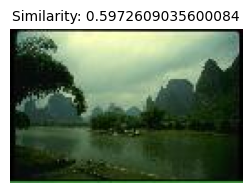

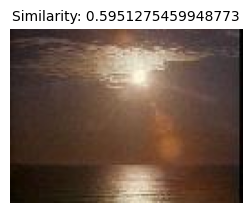

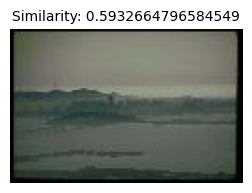

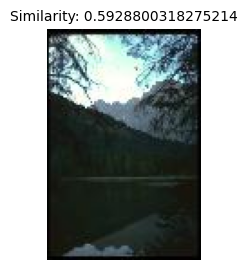

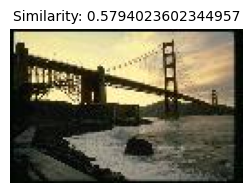

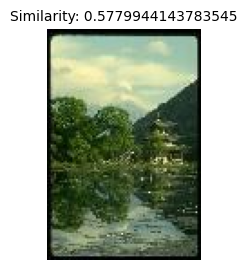

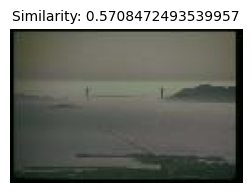

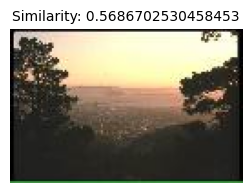

In [56]:
query_image_paths = [
    '/content/images_mr/1885.jpg'
]
top_k = 10
# preprocessed_src_images = preprocess_batches(src_images)
# _, mean, std = preprocessed_src_images
# print(preprocessed_src_images)
preprocessed_src_images = preprocess_batches(src_images)
mean = preprocessed_src_images[1]
std = preprocessed_src_images[2]

for query_image_path in query_image_paths:
  query_image = cv2.imread(query_image_path, 1)
  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
  preprocessed_query_image = preprocess_query(query_image, mean, std)
  print(preprocessed_query_image)

  ranked_list, scores = ranking(
      preprocessed_query_image,
      preprocessed_src_images[0],
      top_k
  )

print('Query Image')
plt.figure(figsize=(3,3))
plt.imshow(query_image)
plt.axis('off')
plt.show()
print(f'Top {top_k} results')
for idx in range(len(ranked_list)):
  src_image_idx = ranked_list[idx]
  similarity_score = scores[idx]
  plt.figure(figsize=(3,3))
  plt.imshow(src_images[src_image_idx])
  plt.title(f'Similarity: {similarity_score}', fontsize=10)
  plt.axis('off')
  plt.show()